In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
EPS = 1e-12
SZ = 1024
TF_DTYPE = tf.float32

In [3]:
def batch_norm(inputs, is_training, decay = 0.9):
    eps = 1e-5
    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    if is_training:
        batch_mean, batch_var = tf.nn.moments(inputs,[0,1,2])
        train_mean = tf.assign(pop_mean,
                               pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var,
                              pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs,
                batch_mean, batch_var, beta, scale, eps)
    else:
        return tf.nn.batch_normalization(inputs,
            pop_mean, pop_var, beta, scale, eps)

def deconv_shape(input, channels_scale, out_channels=None):
  ''' twice the width, specified scale or specified number of channels '''
  if(out_channels is None):
    out_channels = int(int(input.get_shape()[-1]) * channels_scale)
  
  input_size_h = 1 #input.get_shape().as_list()[1]
  input_size_w = int(input.get_shape().as_list()[2] * 2)
  output_shape = tf.stack([tf.shape(input)[0], 
                           input_size_h,
                           input_size_w,
                           out_channels])
  return output_shape

def create_w(shape, name):
  return tf.get_variable(name, shape=shape, initializer=tf.random_normal_initializer(0, 0.02, dtype=TF_DTYPE), dtype=tf.float32)


def create_generator(   generator_inputs,
                        generator_outputs_channels, #not used. remove later
                        ngf,
                        is_training,
                        is_fused):
  # generator encoder filter [h, w, in ch, out ch]
  gen_w01 = create_w(shape=[1, 4,       1, ngf * 1], name="gen_w01")
  gen_w02 = create_w(shape=[1, 4, ngf * 1, ngf * 1], name="gen_w02")
  gen_w03 = create_w(shape=[1, 4, ngf * 1, ngf * 2], name="gen_w03")
  gen_w04 = create_w(shape=[1, 4, ngf * 2, ngf * 2], name="gen_w04")
  gen_w05 = create_w(shape=[1, 4, ngf * 2, ngf * 4], name="gen_w05")
  gen_w06 = create_w(shape=[1, 4, ngf * 4, ngf * 4], name="gen_w06")
  gen_w07 = create_w(shape=[1, 4, ngf * 4, ngf * 4], name="gen_w07")
  gen_w08 = create_w(shape=[1, 4, ngf * 4, ngf * 4], name="gen_w08")
  gen_w09 = create_w(shape=[1, 4, ngf * 4, ngf * 8], name="gen_w09")
  gen_w10 = create_w(shape=[1, 4, ngf * 8, ngf * 8], name="gen_w10")
  # generator decoder filter [h, w, out ch, in ch] ... in and out are reversed!
  gen_w11 = create_w(shape=[1, 4, ngf * 8 * 1, ngf * 8 * 1], name="gen_w11") #128=>128
  gen_w12 = create_w(shape=[1, 4, ngf * 4 * 1, ngf * 8 * 2], name="gen_w12") #256=>64
  gen_w13 = create_w(shape=[1, 4, ngf * 4 * 1, ngf * 4 * 2], name="gen_w13") #128=>64
  gen_w14 = create_w(shape=[1, 4, ngf * 4 * 1, ngf * 4 * 2], name="gen_w14") #128=>64
  gen_w15 = create_w(shape=[1, 4, ngf * 4 * 1, ngf * 4 * 2], name="gen_w15") #128=>64
  gen_w16 = create_w(shape=[1, 4, ngf * 2 * 1, ngf * 4 * 2], name="gen_w16") #128=>32
  gen_w17 = create_w(shape=[1, 4, ngf * 2 * 1, ngf * 2 * 2], name="gen_w17") #128=>32
  gen_w18 = create_w(shape=[1, 4, ngf * 1 * 1, ngf * 2 * 2], name="gen_w18") #64=>16
  gen_w19 = create_w(shape=[1, 4, ngf * 1 * 1, ngf * 1 * 2], name="gen_w19") #32=>16
  gen_w20 = create_w(shape=[1, 4,           1, ngf * 1 * 2], name="gen_w20") #32=>1
  
  #encooder_1
  e01 = tf.nn.conv2d( generator_inputs, gen_w01, strides=(1,1,2,1), padding="SAME")
  #encoder_2
  out = tf.nn.leaky_relu(e01)
  out = tf.nn.conv2d( out, gen_w02, strides=(1,1,2,1), padding="SAME")
  e02 = batch_norm(out, is_training)
  #encoder_3
  out = tf.nn.leaky_relu(e02)
  out = tf.nn.conv2d( out, gen_w03, strides=(1,1,2,1), padding="SAME")
  e03 = batch_norm(out, is_training)
  #encoder_4
  out = tf.nn.leaky_relu(e03)
  out = tf.nn.conv2d( out, gen_w04, strides=(1,1,2,1), padding="SAME")
  e04 = batch_norm(out, is_training)
  #encoder_5
  out = tf.nn.leaky_relu(e04)
  out = tf.nn.conv2d( out, gen_w05, strides=(1,1,2,1), padding="SAME")
  e05 = batch_norm(out, is_training)
  #encoder_6
  out = tf.nn.leaky_relu(e05)
  out = tf.nn.conv2d( out, gen_w06, strides=(1,1,2,1), padding="SAME")
  e06 = batch_norm(out, is_training)
  #encoder_7
  out = tf.nn.leaky_relu(e06)
  out = tf.nn.conv2d( out, gen_w07, strides=(1,1,2,1), padding="SAME")
  e07 = batch_norm(out, is_training)
  #encoder_8
  out = tf.nn.leaky_relu(e07)
  out = tf.nn.conv2d( out, gen_w08, strides=(1,1,2,1), padding="SAME")
  e08 = batch_norm(out, is_training)
  #encoder_9
  out = tf.nn.leaky_relu(e08)
  out = tf.nn.conv2d( out, gen_w09, strides=(1,1,2,1), padding="SAME")
  e09 = batch_norm(out, is_training)
  #encoder_10
  out = tf.nn.leaky_relu(e09)
  out = tf.nn.conv2d( out, gen_w10, strides=(1,1,2,1), padding="SAME")
  e10 = batch_norm(out, is_training)

  print("e01", e01.get_shape()) # [b, 1, 512, 16]
  print("e02", e02.get_shape()) # [b, 1, 256, 16]
  print("e03", e03.get_shape()) # [b, 1, 128, 32]
  print("e04", e04.get_shape()) # [b, 1, 64,  32]
  print("e05", e05.get_shape()) # [b, 1, 32,  64]
  print("e06", e06.get_shape()) # [b, 1, 16,  64]
  print("e07", e07.get_shape()) # [b, 1, 8,   64]
  print("e08", e08.get_shape()) # [b, 1, 4,   64]
  print("e09", e09.get_shape()) # [b, 1, 2,  128]
  print("e10", e10.get_shape()) # [b, 1, 1,  128]

  #decoder_1 [b, 1, 1, 128] => [b, 1, 2, 128]
  out = tf.nn.relu(e10)
  out_shape=deconv_shape(out, 1.0)
  print("d1 deconv2d input=", out.get_shape(), "w11=", gen_w11.get_shape())
  out = tf.nn.conv2d_transpose(out, gen_w11, strides=(1,1,2,1), output_shape=out_shape, padding="SAME")
  print("d1 deconv2d output=", out.get_shape())
  out = batch_norm(out, is_training)
  if(is_training):
    out = tf.nn.dropout(out, keep_prob=1 - 0.5)

  #decoder_2 [b, 1, 2, 128] => [b, 1, 2, 256] => [b, 1, 4, 64]
  out = tf.concat([out, e09], axis=3)
  print("d2 concatting ", out.get_shape(), " + ", e09.get_shape())
  out = tf.nn.relu(out)
  out_shape=deconv_shape(out, 0.25)
  print("d2 deconv2d input=", out.get_shape(), "w12=", gen_w12.get_shape())
  out = tf.nn.conv2d_transpose(out, gen_w12, strides=(1,1,2,1), output_shape=out_shape, padding="SAME")
  print("d2 deconv2d output=", out.get_shape())
  out = batch_norm(out, is_training)
  if(is_training):
    out = tf.nn.dropout(out, keep_prob=1 - 0.5)

  #decoder_3 [b, 1, 4, 64] => [b, 1, 4, 128] => [b, 1, 8, 64]
  print("d3 concatting ", out.get_shape(), " + ", e08.get_shape())
  out = tf.concat([out, e08], axis=3)
  out = tf.nn.relu(out)
  out_shape=deconv_shape(out, 0.5)
  print("d3 deconv2d input=", out.get_shape(), "w13=", gen_w13.get_shape())
  out = tf.nn.conv2d_transpose(out, gen_w13, strides=(1,1,2,1), output_shape=out_shape, padding="SAME")
  print("d3 deconv2d output=", out.get_shape())
  out = batch_norm(out, is_training)
  if(is_training):
    out = tf.nn.dropout(out, keep_prob=1 - 0.5)

  #decoder_4 [b, 1, 8, 64] => [b, 1, 8, 128] => [b, 1, 16, 64]
  out = tf.concat([out, e07], axis=3)
  print("d4 concatting ", out.get_shape(), " + ", e07.get_shape())
  out = tf.nn.relu(out)
  out_shape=deconv_shape(out, 0.5)
  print("d4 deconv2d input=", out.get_shape(), "w14=", gen_w14.get_shape())
  out = tf.nn.conv2d_transpose(out, gen_w14, strides=(1,1,2,1), output_shape=out_shape, padding="SAME")
  print("d4 deconv2d output=", out.get_shape())
  out = batch_norm(out, is_training)

  #decoder_5 [b, 1, 16, 64] => [b, 1, 16, 128] => [b, 1, 32, 64]
  out = tf.concat([out, e06], axis=3)
  print("d5 concatting ", out.get_shape(), " + ", e06.get_shape())
  out = tf.nn.relu(out)
  out_shape=deconv_shape(out, 0.5)
  print("d5 deconv2d input=", out.get_shape(), "w15=", gen_w15.get_shape())
  out = tf.nn.conv2d_transpose(out, gen_w15, strides=(1,1,2,1), output_shape=out_shape, padding="SAME")
  print("d5 deconv2d output=", out.get_shape())
  out = batch_norm(out, is_training)

  #decoder_6 [b, 1, 32, 64] => [b, 1, 32, 128] => [b, 1, 64, 32]
  out = tf.concat([out, e05], axis=3)
  print("d6 concatting ", out.get_shape(), " + ", e05.get_shape())
  out = tf.nn.relu(out)
  out_shape=deconv_shape(out, 0.25)
  print("d6 deconv2d input=", out.get_shape(), "w16=", gen_w16.get_shape())
  out = tf.nn.conv2d_transpose(out, gen_w16, strides=(1,1,2,1), output_shape=out_shape, padding="SAME")
  print("d6 deconv2d output=", out.get_shape())
  out = batch_norm(out, is_training)

  #decoder_7 [b, 1, 64, 32] => [b, 1, 64, 64] => [b, 1, 128, 32]
  out = tf.concat([out, e04], axis=3)
  print("d7 deconcatting ", out.get_shape(), " + ", e04.get_shape())
  out = tf.nn.relu(out)
  out_shape=deconv_shape(out, 0.5)
  print("d7 deconv2d input=", out.get_shape(), "w17=", gen_w17.get_shape())
  out = tf.nn.conv2d_transpose(out, gen_w17, strides=(1,1,2,1), output_shape=out_shape, padding="SAME")
  print("d7 deconv2d output=", out.get_shape())
  out = batch_norm(out, is_training)

  #decoder_8 [b, 1, 128, 32] => [b, 1, 128, 64] => [b, 1, 256, 16]
  print("d8 concatting ", out.get_shape(), " + ", e03.get_shape())
  out = tf.concat([out, e03], axis=3)
  out = tf.nn.relu(out)
  out_shape=deconv_shape(out, 0.25)
  print("out_shape=", out_shape)
  print("d8 deconv2d input=", out.get_shape(), "w18=", gen_w18.get_shape())
  out = tf.nn.conv2d_transpose(out, gen_w18, strides=(1,1,2,1), output_shape=out_shape, padding="SAME", name="deconv8")
  print("d8 deconv2d output=", out.get_shape())
  out = batch_norm(out, is_training)

  #decoder_9 [b, 1, 256, 16] => [b, 1, 256, 32] => [b, 1, 512, 16]
  print("d9 concatting ", out.get_shape(), " + ", e02.get_shape())
  out = tf.concat([out, e02], axis=3)
  out = tf.nn.relu(out)
  out_shape=deconv_shape(out, 0.5)
  print("out_shape=", out_shape)
  print("d9 deconv2d input=", out.get_shape(), "w19=", gen_w19.get_shape())
  out = tf.nn.conv2d_transpose(out, gen_w19, strides=(1,1,2,1), output_shape=out_shape, padding="SAME", name="deconv9")
  print("d9 deconv2d output=", out.get_shape())
  out = batch_norm(out, is_training)

  #decoder_10 [b, 1, 512, 16] => [b, 1, 512, 32] => [b, 1, 512, 1]
  print("d10 concatting ", out.get_shape(), " + ", e01.get_shape())
  out = tf.concat([out, e01], axis=3)
  out = tf.nn.relu(out)
  out_shape=deconv_shape(out, 0.0, 1) #[b, 1, 2*512, 1)
  print("d10 deconv2d input=", out.get_shape(), "w20=", gen_w20.get_shape())
  out = tf.nn.conv2d_transpose(out, gen_w20, strides=(1,1,2,1), output_shape=out_shape, padding="SAME", name="deconv10")
  print("d10 deconv2d output=", out.get_shape())
  out = tf.tanh(out)

  return out



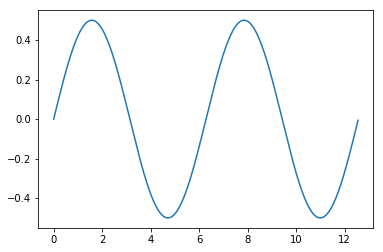

In [4]:
indice=np.arange(1024)
param=(4.0*np.pi)/1024.0 * indice
x=np.sin(param, dtype=np.float32) * 0.5
plt.plot(param, x)

e01 (1, 1, 512, 32)
e02 (1, 1, 256, 32)
e03 (1, 1, 128, 64)
e04 (1, 1, 64, 64)
e05 (1, 1, 32, 128)
e06 (1, 1, 16, 128)
e07 (1, 1, 8, 128)
e08 (1, 1, 4, 128)
e09 (1, 1, 2, 256)
e10 (1, 1, 1, 256)
d1 deconv2d input= (1, 1, 1, 256) w11= (1, 4, 256, 256)
d1 deconv2d output= (1, 1, 2, 256)
d2 concatting  (1, 1, 2, 512)  +  (1, 1, 2, 256)
d2 deconv2d input= (1, 1, 2, 512) w12= (1, 4, 128, 512)
d2 deconv2d output= (1, 1, 4, 128)
d3 concatting  (1, 1, 4, 128)  +  (1, 1, 4, 128)
d3 deconv2d input= (1, 1, 4, 256) w13= (1, 4, 128, 256)
d3 deconv2d output= (1, 1, 8, 128)
d4 concatting  (1, 1, 8, 256)  +  (1, 1, 8, 128)
d4 deconv2d input= (1, 1, 8, 256) w14= (1, 4, 128, 256)
d4 deconv2d output= (1, 1, 16, 128)
d5 concatting  (1, 1, 16, 256)  +  (1, 1, 16, 128)
d5 deconv2d input= (1, 1, 16, 256) w15= (1, 4, 128, 256)
d5 deconv2d output= (1, 1, 32, 128)
d6 concatting  (1, 1, 32, 256)  +  (1, 1, 32, 128)
d6 deconv2d input= (1, 1, 32, 256) w16= (1, 4, 64, 256)
d6 deconv2d output= (1, 1, 64, 64)
d7 deco

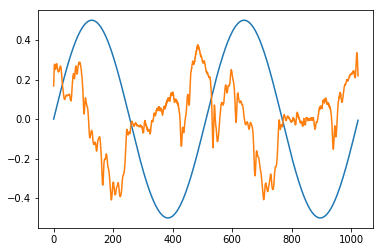

In [7]:
tf.reset_default_graph()

input = tf.placeholder(name="input", dtype=tf.float32, shape=(1, 1, 1024, 1))
with tf.variable_scope("generator"):
  generator = create_generator(input, 1, 32, False, False)

saver = tf.train.Saver()

input_val=x.reshape([1,1,1024,1])
with tf.Session() as sess:
    saver.restore(sess,"../data/output/pretrained_model/model.ckpt-7001")
    out_eval = sess.run(generator, feed_dict={input:input_val})
    
    output_graph_def = tf.graph_util.convert_variables_to_constants(
      sess, # The session is used to retrieve the weights
      tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
      ["generator/Tanh"]
    ) 
    
    # Finally we serialize and dump the output graph to the filesystem
    with tf.gfile.GFile("../data/output/pretrained_model/frozen_model.pb", "wb") as f:
      f.write(output_graph_def.SerializeToString())
    
    # save
    converter = tf.contrib.lite.TFLiteConverter.from_frozen_graph(
      graph_def_file="../data/output/pretrained_model/frozen_model.pb",
      input_arrays=["input"],
      output_arrays=["generator/Tanh"])
    tflite_model = converter.convert()
    open("../data/output/pretrained_model/converted_model.tflite", "wb").write(tflite_model)
    #converter = tf.lite.TFLiteConverter.from_session(sess, [input], [generator])
    #tflite_model = converter.convert()
    #open("converted_model.tflite", "wb").write(tflite_model)

plt.plot(np.arange(1024), input_val[0,0,:,0])
plt.plot(np.arange(1024), out_eval[0,0,:,0])

[{'shape': array([   1,    1, 1024,    1], dtype=int32), 'name': 'input', 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'index': 142}]
[{'shape': array([   1,    1, 1024,    1], dtype=int32), 'name': 'generator/Tanh', 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'index': 48}]
<class 'numpy.float32'>
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]]


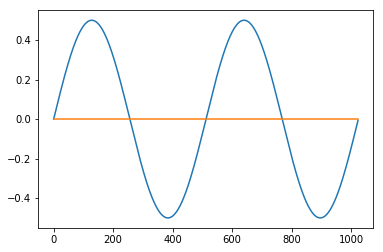

In [8]:
# Load TFLite model and allocate tensors.
interpreter = tf.contrib.lite.Interpreter(model_path="../data/output/pretrained_model/converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)
print(type(input_val[0,0,0,0]))

# Test model on random input data.
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], input_val)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
plt.plot(np.arange(1024), input_val[0,0,:,0])
plt.plot(np.arange(1024), output_data[0,0,:,0])